In [1]:
import pandas as pd
import math
import warnings
import yfinance as yf
import QuantLib as ql
from datetime import timedelta
from HestonModel import Heston, HestonPriceFunction
from Heston import HestonParameters, get_metrics, calculate_expected_variance_over_strikes
warnings.filterwarnings("ignore")


heston = Heston()
heston.load_data('Data/20230912_PLIQ_IP.csv')
heston.preprocess_data()
heston.clean['Spot'] = heston.clean.Futuro * (-heston.clean['Tasa de Interes'] * heston.clean['Plazo a Vencimiento']).apply(lambda x: math.exp(x))
heston.clean

,Fecha,TV,Emisora,Serie,Vencimiento,Tasa de Interes,Plazo a Vencimiento,Futuro,Pliq,Bid,Ask,Call o Put,Hubo Bid/Ask,Volatilidad,V. Teorico,Mes_vencimiento,Spot
0,2023-09-12,OI,IP,40000,C,0.119300,0.513889,53969,15676.0,0.0,0.0,0,0,0.587818,15676.291368,3,50759.706626
1,2023-09-12,OI,IP,40500,C,0.119300,0.513889,53969,15295.0,0.0,0.0,0,0,0.581875,15294.629056,3,50759.706626
2,2023-09-12,OI,IP,41000,C,0.119300,0.513889,53969,14915.0,0.0,0.0,0,0,0.575899,14914.803711,3,50759.706626
3,2023-09-12,OI,IP,41500,C,0.119300,0.513889,53969,14537.0,0.0,0.0,0,0,0.569911,14537.058921,3,50759.706626
4,2023-09-12,OI,IP,42000,C,0.119300,0.513889,53969,14161.0,0.0,0.0,0,0,0.563888,14161.207052,3,50759.706626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,2023-09-12,OI,IP,68000,X,0.116797,0.261111,52515,15685.0,0.0,0.0,1,0,0.417201,15685.461471,12,50937.625186
484,2023-09-12,OI,IP,68500,X,0.116797,0.261111,52515,16165.0,0.0,0.0,1,0,0.424280,16165.480807,12,50937.625186
485,2023-09-12,OI,IP,69000,X,0.116797,0.261111,52515,16646.0,0.0,0.0,1,0,0.431235,16645.517159,12,50937.625186
486,2023-09-12,OI,IP,69500,X,0.116797,0.261111,52515,17126.0,0.0,0.0,1,0,0.438069,17125.566692,12,50937.625186


In [3]:
import pandas as pd
import math
import warnings
import yfinance as yf
import QuantLib as ql
from datetime import timedelta
from HestonModel import Heston, HestonPriceFunction
#from V4 import HestonParameters, get_metrics, calculate_expected_variance_over_strikes
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
warnings.filterwarnings("ignore")

In [1]:
from HestonVolatilitiesUI import HestonModule
import pandas as pd
heston = HestonModule('AAPL')
heston.get_dividend(0)
heston.opt_type("Put")
results, vols = heston.get_results()

ValueError: cannot reindex on an axis with duplicate labels

In [16]:
params_df = results[['Params', 'TTM']].copy()
params_df[['v0', 'kappa', 'theta', 'sigma', 'rho']] = pd.DataFrame(params_df['Params'].tolist(), index=params_df.index)
params_df.drop(columns='Params', inplace=True)
params_df = params_df.fillna(0)

import numpy as np
def expected_variance(v0, kappa, theta, t):
    return theta + (v0 - theta) * np.exp(-kappa * t)

params_df['Expected_Variance'] = params_df.apply(lambda row: expected_variance(row['v0'], row['kappa'], row['theta'], row['TTM']), axis=1)

expected_variance_df = pd.DataFrame({
        'Strike_Price': results['Strike'],
        'Expected_Variance': params_df['Expected_Variance']
    }).set_index('Strike_Price')

expected_variance_df

,Expected_Variance
Strike_Price,
100.0,1.028131
150.0,0.070568
155.0,0.123589
160.0,0.035049
165.0,0.071879
170.0,0.055123
175.0,0.041107
180.0,0.034869
185.0,0.030916


In [9]:
pd.concat(results)

,Optimizer,Success,Params,Strike,TTM,Objective_Value,Estimated_Price,Market_Price,MSE
0,TNC,True,"[1.0, 1.1182194670049197, 1.2766640291370306, ...",100.0,0.095890,3.548082e+00,76.136365,78.02,3.548082e+00
0,TNC,True,"[0.06785286513552807, 0.10215653282726789, 0.5...",150.0,0.054795,1.068849e-13,26.710000,26.71,1.068849e-13
0,TNC,True,"[0.1221724999026585, 0.08594496778924776, 0.42...",155.0,0.054795,4.544188e-15,22.050000,22.05,4.544188e-15
0,TNC,True,"[0.03332365716869212, 0.09747832622894481, 0.3...",160.0,0.054795,2.690828e-16,16.730000,16.73,2.690828e-16
0,TNC,True,"[0.0705992719156559, 0.10351906641393915, 0.29...",165.0,0.054795,3.415603e-16,12.490000,12.49,3.415603e-16
0,TNC,True,"[0.05362881127095953, 0.13543483878647655, 0.2...",170.0,0.054795,1.943701e-14,8.100000,8.10,1.943701e-14
0,TNC,True,"[0.039779017056441546, 0.13577576616432585, 0....",175.0,0.054795,4.175799e-14,4.300000,4.30,4.175799e-14
0,TNC,True,"[0.03397685623505231, 0.10009219280054749, 0.1...",180.0,0.054795,4.411439e-14,1.790000,1.79,4.411439e-14
0,TNC,True,"[0.029919211088092035, 0.11537595180272042, 0....",185.0,0.054795,1.830023e-14,0.530000,0.53,1.830023e-14
0,TNC,True,"[0.03309836439692354, 0.09150727649113566, 0.1...",190.0,0.054795,3.667108e-15,0.170000,0.17,3.667108e-15


In [7]:
from Heston import HestonParameters, get_metrics, calculate_expected_variance_over_strikes, to_ql_dates, simple_plot
from HestonModel import Heston, HestonPriceFunction
from datetime import timedelta
import yfinance as yf
import QuantLib as ql
import pandas as pd
import numpy as np
import warnings
import math

ticker_symbol = 'AAPL' # Will be provided by user
call_or_put = 'Call' # Will be provided by user

ticker_data = yf.Ticker(ticker_symbol)
options_expirations = ticker_data.options
expiration_date = options_expirations[2]
options_chain = ticker_data.option_chain(expiration_date)

if call_or_put == 'Call':
    option = options_chain.calls
elif call_or_put == 'Put':
    option = options_chain.puts

option = option.dropna()
option = option[option['volume']  > 10]
option['Maturity'] = expiration_date
option['Maturity'] = pd.to_datetime(option['Maturity'])
option['lastTradeDate'] = pd.to_datetime(option['lastTradeDate']).dt.tz_localize(None)
option['TTM'] = (pd.to_datetime(option['Maturity']) - option['lastTradeDate']).dt.days / 365.0

trade_dates = option['lastTradeDate']
start_date, end_date = trade_dates.min(), trade_dates.max()
end_date = end_date + timedelta(days = 1)
prices = yf.download(ticker_symbol, start = start_date, end = end_date, progress = False)['Adj Close'].reset_index()
option['lastTradeDate'] = option['lastTradeDate'].apply(lambda x: x.strftime('%Y-%m-%d'))
prices['Date'] = prices['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
option = option.merge(prices, left_on = 'lastTradeDate', right_on = 'Date', how = 'left').drop('Date', axis = 1).rename( columns = {'Adj Close':'Price'})
option['lastTradeDate'] = option['lastTradeDate'].apply(to_ql_dates)
option['Maturity'] = option['Maturity'].apply(to_ql_dates)

spots = option['Price'].values
strikes = option['strike'].values
mkts = option['lastPrice'].values
dividend = .00
vols = option['impliedVolatility'].values
calc = option['lastTradeDate'].values
maturities = option['Maturity'].values
ttms = option['TTM'].values

results = [HestonParameters(spot_price, strike_price, market_price, dividend, [.1, .1, historical_volatility, .1, .1], calculation_date, maturity_date, ttm) for 
spot_price, strike_price, market_price, historical_volatility, calculation_date, maturity_date, ttm in zip(spots, strikes, mkts, vols, calc, maturities, ttms)]

In [8]:
get_metrics(results) # Calculation Metrics

,Success,MSE
Optimizer,,
TNC,200.0%,6.291197


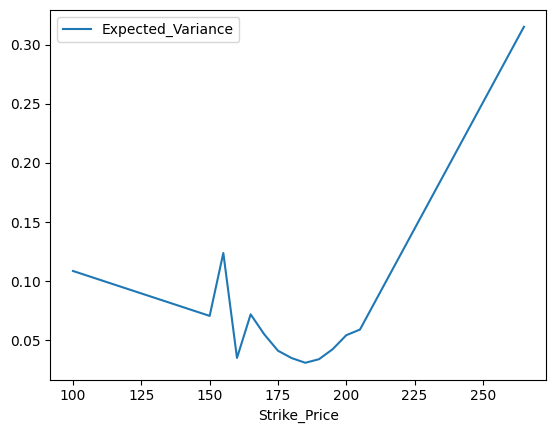

In [9]:
simple_plot(results)

<Axes: xlabel='Strike_Price'>

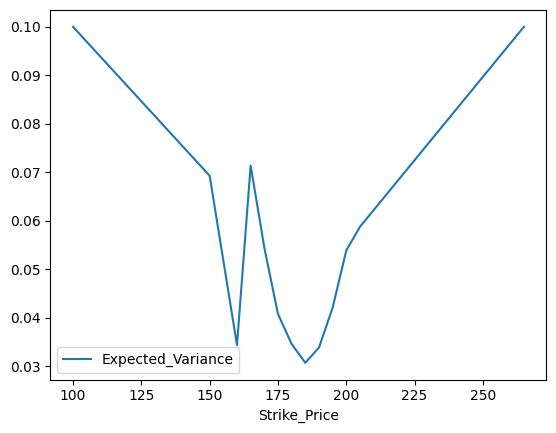

In [78]:


# CALLS
ticker_symbol = 'AAPL'
ticker_data = yf.Ticker(ticker_symbol)
options_expirations = ticker_data.options
expiration_date = options_expirations[2]
options_chain = ticker_data.option_chain(expiration_date)
calls = options_chain.calls
puts = options_chain.puts
calls = calls.dropna()
calls = calls[calls['volume']  > 10]
calls['Maturity'] = expiration_date
calls['Maturity'] = pd.to_datetime(calls['Maturity'])
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate']).dt.tz_localize(None)
calls['TTM'] = (pd.to_datetime(calls['Maturity']) - calls['lastTradeDate']).dt.days / 365.0



trade_dates = calls['lastTradeDate']
start_date, end_date = trade_dates.min(), trade_dates.max()
end_date = end_date + timedelta(days = 1)
prices = yf.download(ticker_symbol, start = start_date, end = end_date, progress = False)['Adj Close'].reset_index()
calls['lastTradeDate'] = calls['lastTradeDate'].apply(lambda x: x.strftime('%Y-%m-%d'))
prices['Date'] = prices['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
calls = calls.merge(prices, left_on = 'lastTradeDate', right_on = 'Date', how = 'left').drop('Date', axis = 1).rename( columns = {'Adj Close':'Price'})
calls['lastTradeDate'] = calls['lastTradeDate'].apply(to_ql_dates)
calls['Maturity'] = calls['Maturity'].apply(to_ql_dates)

spots = calls['Price'].values
strikes = calls['strike'].values
mkts = calls['lastPrice'].values
dividend = .00
vols = calls['impliedVolatility'].values
calc = calls['lastTradeDate'].values
maturities = calls['Maturity'].values
ttms = calls['TTM'].values

# Initial parameter guess
prev_year = end_date - timedelta(days=365)
prev_prices = yf.download(ticker_symbol, start = prev_year, end = end_date, progress = False)['Adj Close']
def log_ret(series):
    return np.log(series / series.shift(1))
# V0
v0_guess = log_ret(prev_prices)
v0_guess = v0_guess.std() # Initial V0
# Sigma / Epsilon
sigma_guess = logret.groupby('Date')['Adj Close'].std()
sigma_guess = sigma_guess.std()  # Initial Sigma
# Kappa
kappa_guess = sigma_guess **2 / 2*theta_guess +.001

results = [HestonParameters(spot_price, strike_price, market_price, dividend, [.1, .1, .1, .1, .1], calculation_date, maturity_date, ttm) for 
spot_price, strike_price, market_price, historical_volatility, calculation_date, maturity_date, ttm in zip(spots, strikes, mkts, vols, calc, maturities, ttms)]
metrics = get_metrics(results)


combined_results_df = pd.concat(results, ignore_index=True).dropna()
# Now you can calculate the expected variance over strikes
expected_variance_df = calculate_expected_variance_over_strikes(combined_results_df)
expected_variance_df.plot()

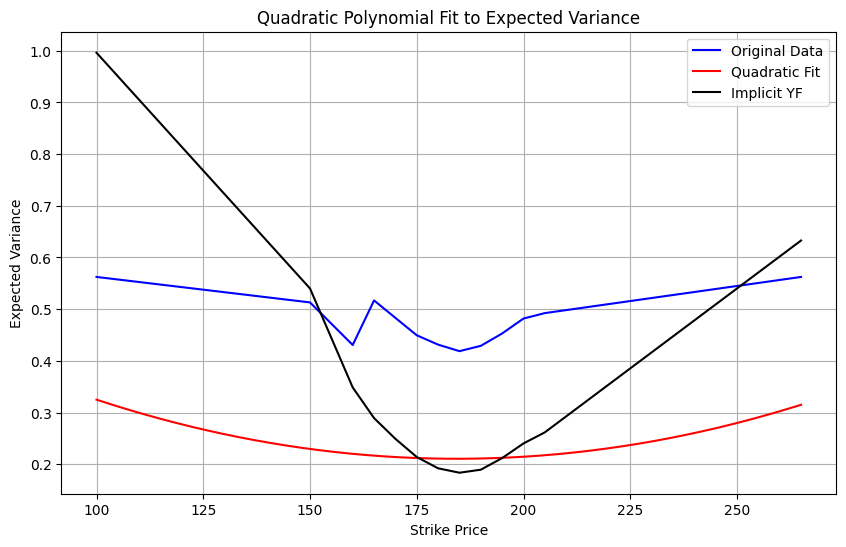

In [93]:
import matplotlib.pyplot as plt
strike_price = expected_variance_df.index.values
expected_variance = np.sqrt(expected_variance_df['Expected_Variance'].values)
yahoo = calls[['strike','impliedVolatility']]

# Fit a quadratic polynomial (2nd degree polynomial)
coefficients = np.polyfit(strike_price, expected_variance, 2)

# Generate a sequence of strike prices for the purpose of plotting the polynomial
x_fit = np.linspace(strike_price.min(), strike_price.max(), 400)
# Calculate the expected variance using the polynomial coefficients
y_fit = np.polyval(coefficients, x_fit)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(strike_price, np.sqrt(expected_variance), color = 'blue',label='Original Data')
plt.plot(x_fit, y_fit, color='red', label='Quadratic Fit')
plt.plot(calls.strike, calls.impliedVolatility, color = 'black', label ='Implicit YF')
plt.xlabel('Strike Price')
plt.ylabel('Expected Variance')
plt.title('Quadratic Polynomial Fit to Expected Variance')
plt.legend()
plt.grid(True)
plt.show()


In [81]:
regression = pd.DataFrame([x_fit,y_fit], index = ['strike','vol']).T
regression[regression['strike'] > 150]

,strike,vol
121,150.037594,0.054647
122,150.451128,0.054414
123,150.864662,0.054182
124,151.278195,0.053954
125,151.691729,0.053729
...,...,...
395,263.345865,0.097029
396,263.759398,0.097575
397,264.172932,0.098124
398,264.586466,0.098676


<Axes: xlabel='strike'>

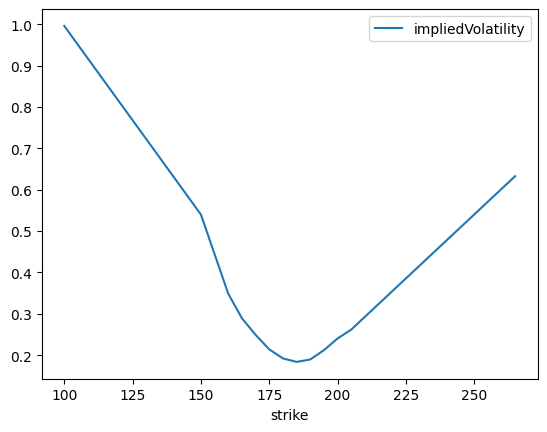

In [5]:
calls[['strike','impliedVolatility']].set_index('strike').plot()

In [5]:
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Maturity,TTM,Price
0,AAPL231124C00100000,"October 19th, 2023",100.0,78.02,76.15,77.30,0.000000,0.000000,32.0,19,0.996094,True,REGULAR,USD,"November 24th, 2023",0.095890,175.460007
1,AAPL231124C00150000,"November 3rd, 2023",150.0,26.71,26.55,27.60,-1.060001,-3.817074,34.0,21,0.540044,True,REGULAR,USD,"November 24th, 2023",0.054795,176.649994
2,AAPL231124C00160000,"November 3rd, 2023",160.0,16.73,16.95,17.40,-1.600000,-8.728862,60.0,458,0.348639,True,REGULAR,USD,"November 24th, 2023",0.054795,176.649994
3,AAPL231124C00165000,"November 3rd, 2023",165.0,12.49,12.25,12.60,-1.210000,-8.832117,234.0,618,0.289314,True,REGULAR,USD,"November 24th, 2023",0.054795,176.649994
4,AAPL231124C00170000,"November 3rd, 2023",170.0,8.10,7.90,8.20,-1.799999,-18.181810,616.0,1821,0.249153,True,REGULAR,USD,"November 24th, 2023",0.054795,176.649994
5,AAPL231124C00175000,"November 3rd, 2023",175.0,4.30,4.30,4.40,-2.100000,-32.812496,2343.0,3655,0.213997,True,REGULAR,USD,"November 24th, 2023",0.054795,176.649994
6,AAPL231124C00180000,"November 3rd, 2023",180.0,1.79,1.73,1.80,-1.860000,-50.958908,4676.0,3867,0.192147,False,REGULAR,USD,"November 24th, 2023",0.054795,176.649994
7,AAPL231124C00185000,"November 3rd, 2023",185.0,0.53,0.51,0.56,-1.160000,-68.639060,3432.0,3933,0.183602,False,REGULAR,USD,"November 24th, 2023",0.054795,176.649994
8,AAPL231124C00190000,"November 3rd, 2023",190.0,0.17,0.15,0.17,-0.500000,-74.626860,1889.0,6734,0.189461,False,REGULAR,USD,"November 24th, 2023",0.054795,176.649994
9,AAPL231124C00195000,"November 3rd, 2023",195.0,0.08,0.02,0.08,-0.190000,-70.370370,431.0,2942,0.211922,False,REGULAR,USD,"November 24th, 2023",0.054795,176.649994


<Axes: xlabel='Strike'>

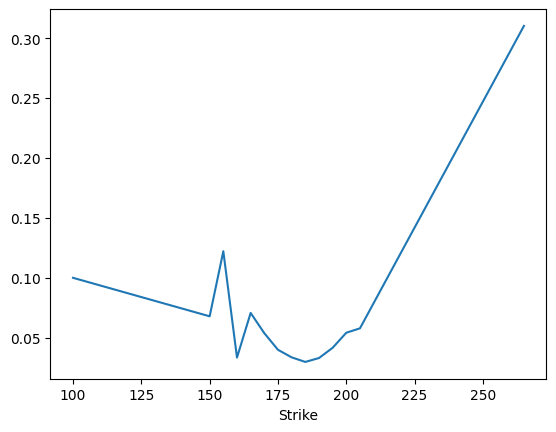

In [4]:
v0_df = pd.concat(results, axis = 0)
v0_df = v0_df[v0_df['Success']==True]
v0_df.Params = v0_df.Params.apply(lambda x: x[0])
v0_df.set_index('Strike').Params.plot()

In [213]:
from datetime import timedelta
# Definir el ticker para Google

ticker_symbol = 'AAPL'
ticker_data = yf.Ticker(ticker_symbol)
options_expirations = ticker_data.options
expiration_date = options_expirations[2]
options_chain = ticker_data.option_chain(expiration_date)
calls = options_chain.calls
puts = options_chain.puts
puts['Maturity'] = expiration_date

def to_ql_dates(date):
    date = pd.to_datetime(date)
    return ql.Date(date.day, date.month, date.year)

trade_dates = puts['lastTradeDate']
start_date, end_date = trade_dates.min(), trade_dates.max()
end_date = end_date + timedelta(days = 1)
prices = yf.download(ticker_symbol, start = start_date, end = end_date, progress = False)['Adj Close'].reset_index()
puts['lastTradeDate'] = puts['lastTradeDate'].apply(lambda x: x.strftime('%Y-%m-%d'))
prices['Date'] = prices['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
puts = puts.merge(prices, left_on = 'lastTradeDate', right_on = 'Date', how = 'left').drop('Date', axis = 1).rename( columns = {'Adj Close':'Price'})
puts['lastTradeDate'] = puts['lastTradeDate'].apply(to_ql_dates)
puts['Maturity'] = puts['Maturity'].apply(to_ql_dates)

spots = puts['Price'].values
strikes = puts['strike'].values
mkts = puts['lastPrice'].values
dividend = .0
vols = puts['impliedVolatility'].values
calc = puts['lastTradeDate'].values
maturities = puts['Maturity'].values


results = [HestonParameters(spot_price, strike_price, market_price, dividend, traditional_implied_volatility, calculation_date, maturity_date, call_option = False) for 
spot_price, strike_price, market_price, traditional_implied_volatility, calculation_date, maturity_date in zip(spots, strikes, mkts, vols, calc, maturities)]
get_metrics(results)

50.0
Optimizer TNC Estimated Price: 6.820682195484479e-13 Market Price: 0.01
75.0
Optimizer TNC Estimated Price: -3.619299858421748e-13 Market Price: 0.01
80.0
Optimizer TNC Estimated Price: -2.1887950779050534e-13 Market Price: 0.01
90.0
Optimizer TNC Estimated Price: 2.2806178603825614e-12 Market Price: 0.01
95.0
Optimizer TNC Estimated Price: -2.5696665812391084e-13 Market Price: 0.01
100.0
Optimizer TNC Estimated Price: 3.1774480275478633e-12 Market Price: 0.01
105.0
Optimizer TNC Estimated Price: 2.2545356677758378e-10 Market Price: 0.01
110.0
Optimizer TNC Estimated Price: 7.185804031921892e-10 Market Price: 0.01
115.0
Optimizer TNC Estimated Price: 1.605239303454808e-08 Market Price: 0.03
120.0
Optimizer TNC Estimated Price: 0.030000001909594065 Market Price: 0.03
125.0
Optimizer TNC Estimated Price: 0.03999982636317434 Market Price: 0.04
130.0
Optimizer TNC Estimated Price: 0.049986163642953496 Market Price: 0.05
135.0
Optimizer TNC Estimated Price: 0.0700003834802514 Market Pr

,Success,MSE
Optimizer,,
TNC,200.0%,0.041012


In [238]:
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Maturity,TTM,Price
0,AAPL231124C00050000,"November 3rd, 2023",50.0,125.70,126.15,127.30,-1.730003,-1.357611,1.0,2,2.105473,True,REGULAR,USD,"November 24th, 2023",0.054795,176.649994
1,AAPL231124C00090000,"November 1st, 2023",90.0,81.35,86.20,87.30,0.000000,0.000000,1.0,1,1.207035,True,REGULAR,USD,"November 24th, 2023",0.060274,173.970001
2,AAPL231124C00095000,"October 25th, 2023",95.0,77.10,81.15,82.30,0.000000,0.000000,NaN,1,1.078130,True,REGULAR,USD,"November 24th, 2023",0.079452,171.100006
3,AAPL231124C00100000,"October 19th, 2023",100.0,78.02,76.15,77.30,0.000000,0.000000,32.0,19,0.996094,True,REGULAR,USD,"November 24th, 2023",0.095890,175.460007
4,AAPL231124C00105000,"October 25th, 2023",105.0,67.15,71.15,72.35,0.000000,0.000000,NaN,1,0.951172,True,REGULAR,USD,"November 24th, 2023",0.079452,171.100006


In [212]:
t = 1  # Time in years until option maturity
expected_variance_df = calculate_expected_variance_over_strikes(results_df, t)

NameError: name 'results_df' is not defined

In [162]:
## V1 Testing BOTH

import QuantLib as ql
import pandas as pd
from scipy.optimize import minimize

def HestonParametersComparisson(spot_price, strike_price, market_price, dividend_yield, traditional_implied_volatility, calculation_date, maturity_date, risk_free_rate = .00525, call_option = True):
    print(strike_price)
    day_count = ql.Actual365Fixed()
    calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

    # Set up the QuantLib environment
    ql.Settings.instance().evaluationDate = calculation_date
    if call_option:
        option_type = ql.Option.Call  # or ql.Option.Put for a put option
    else:
        option_type = ql.Option.Put
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    exercise = ql.EuropeanExercise(maturity_date)
    european_option = ql.VanillaOption(payoff, exercise)

    # Initial parameters for the Heston model
    initial_v0 = 0.1
    initial_kappa = 0.1
    initial_theta = traditional_implied_volatility
    initial_sigma = 0.1
    initial_rho = 0.1

    # Define the optimization objective function
    def objective_function(params):
        v0, kappa, theta, sigma, rho = params

        heston_process = ql.HestonProcess(
            ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count)),
            ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_yield, day_count)),
            ql.QuoteHandle(ql.SimpleQuote(spot_price)),
            v0, kappa, theta, sigma, rho
        )

        model = ql.HestonModel(heston_process)
        engine = ql.AnalyticHestonEngine(model)
        european_option.setPricingEngine(engine)

        model_price = european_option.NPV()
        error = (model_price - market_price) ** 2  # Squared error
        return error, model_price  # Return both error and the model price

    # Bounds for the parameters, excluding theta which is input by the user
    bounds = [(0.0001, 1.0), (0.0001, 2.0), (traditional_implied_volatility * 0.5, traditional_implied_volatility * 1.5), (0.0001, 1.0), (-0.999, 0.999)]

    # Initial parameter guesses, excluding theta which is input by the user
    initial_guess = [0.1, 0.1, traditional_implied_volatility, 0.1, 0.1]

    # Dictionary of optimizers to test, removing poor performers
    optimizers = {
        'L-BFGS-B': {'method': 'L-BFGS-B'},
        'TNC': {'method': 'TNC'},
    }

    # DataFrame to collect results
    results_df = pd.DataFrame(columns=['Optimizer', 'Success', 'Params', 'Objective_Value', 'Estimated_Price', 'Market_Price', 'MSE'])

    # Run optimizers and collect results
    for name, opt in optimizers.items():
        
        # Run the optimizer and capture the additional returned value
        result = minimize(lambda x: objective_function(x)[0], initial_guess, method=opt['method'], bounds=bounds)
        
        success = result.success
        params = result.x if success else None
        # Now retrieve the full result from the objective function which includes the error and the model price
        objective_value, estimated_price = objective_function(params) if success else (None, None)
        error = (estimated_price - market_price) if success else None
        print('Optimizer ', name,'Estimated Price: ', estimated_price, ' Market Price: ', market_price)
        # Create a temporary DataFrame and concatenate it to the main DataFrame
        temp_df = pd.DataFrame({
            'Optimizer': [name],
            'Success': [success],
            'Params': [params],
            'Objective_Value': [objective_value],
            'Estimated_Price': [estimated_price],
            'Market_Price': [market_price if success else None],
            'MSE': [error]
        })
        results_df = pd.concat([results_df, temp_df], ignore_index=True)
        results_df['MSE'] = results_df['MSE'].fillna(0).apply(lambda x: x**2)
    # Print the DataFrame
    return results_df.sort_values(by='MSE', ascending= True)


In [25]:
from datetime import datetime, timedelta
from scipy.optimize import basinhopping
import QuantLib as ql
import numpy as np

def optimize_params(market_price, strike_price, maturity, risk_free_rate, option_type, spot_price, current_date, yearly_historical_volatility):
    # Define bounds for the parameters
    bounds = [(0.0001, 5), (0.0001, 5), (0.0001, 5), (0.0001, 5), (-0.999, 0.999)]

    # Initial guess for the parameters based on historical volatility
    initial_params = [yearly_historical_volatility ** 2, 2.0, yearly_historical_volatility ** 2, 0.1, -0.7]

    # Objective function adapted for the single derivative
    def objective_function(params):
        return objective_function_single_derivative(params, market_price, strike_price, maturity, risk_free_rate, option_type, spot_price, current_date)

    # The basinhopping algorithm
    minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds}
    result = basinhopping(objective_function, initial_params, minimizer_kwargs=minimizer_kwargs)

    # Results
    optimized_params = result.x
    minimum_error = result.fun

    print('Minimum error:', minimum_error)
    print('Optimized parameters:', optimized_params)
    
    return optimized_params

def objective_function_single_derivative(params, market_price, strike_price, maturity, risk_free_rate, option_type, spot_price, current_date):
    v0, kappa, theta, sigma, rho = params

    # Check for parameter validity
    if v0 <= 0 or theta <= 0 or kappa <= 0 or sigma <= 0 or not (-1 < rho < 1) or 2 * kappa * theta <= sigma**2:
        return np.inf  # Return a "penalty" value indicating bad parameters

    model_price = heston_price_function(strike_price, spot_price, np.sqrt(v0), risk_free_rate, kappa, sigma, rho, theta, current_date, maturity, option_type)
    error = (model_price - market_price) ** 2
    return error

def heston_price_function(strike_price, spot_price, v0, risk_free_rate, kappa, sigma, rho, theta, current_date, maturity, option_type):
    # Convert the volatility input into variance
    variance = v0 ** 2
    
    # Calendar and Day count convention
    calendar = ql.UnitedStates()
    day_count = ql.Actual365Fixed()

    # Option type
    ql_option_type = ql.Option.Call if option_type.lower() == 'call' else ql.Option.Put
    
    # Create QuantLib dates from the current date and maturity
    valuation_date = ql.Date(current_date.day, current_date.month, current_date.year)
    maturity_date = valuation_date + int(maturity * 365.25)
    ql.Settings.instance().evaluationDate = valuation_date
    
    # Payoff and Exercise
    payoff = ql.PlainVanillaPayoff(ql_option_type, strike_price)
    exercise = ql.EuropeanExercise(maturity_date)

    # Heston process setup
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(valuation_date, risk_free_rate, day_count))
    dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(valuation_date, 0.0, day_count))
    heston_process = ql.HestonProcess(flat_ts, dividend_yield, spot_handle, variance, kappa, theta, sigma, rho)

    # Heston model setup
    heston_model = ql.HestonModel(heston_process)
    
    # Pricing engine
    engine = ql.AnalyticHestonEngine(heston_model)
    european_option = ql.VanillaOption(payoff, exercise)
    european_option.setPricingEngine(engine)

    # Price calculation
    try:
        price = european_option.NPV()
        return price
    except RuntimeError as e:
        print("Runtime error in pricing:", e)
        return np.inf  # Return a "penalty" value

# Example usage:
market_price = 10  # Example market price
strike_price = 100
maturity = 1  # Maturity in years
risk_free_rate = 0.01  # Risk-free rate
option_type = 'call'  # 'call' or 'put'
spot_price = 100
current_date = datetime.today()  # Replace with your actual date object
yearly_historical_volatility = 0.20

# Optimize parameters
optimized_parameters = optimize_params(
    market_price, strike_price, maturity, risk_free_rate,
    option_type, spot_price, current_date, yearly_historical_volatility
)
